# Program für Roboter- und Computervision

## Importieren der Bibliotheken

In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
# for Rotation only cutting the picture
import argparse
import imutils as im
import csv
import sqlite3

## Importieren der PLZ-Datenbank aus einer CSV-Datei in eine SQLite Datenbank

In [62]:
#csv_path = './Datenbanken CSV/zuordnung_plz_ort.csv'
# Existenz feststellen
#if os.path.exists("orteDE.db"):
#    print("Datei bereits vorhanden")
#    sys.exit(0)

# Verbindung zur Datenbank erzeugen
#connection = sqlite3.connect("orteDE.db")

# Datensatz-Cursor erzeugen
#cursor = connection.cursor()

# Datenbanktabelle erzeugen
#sql = "CREATE TABLE orte(" \
#      "ortsname TEXT, " \
#      "plz INTEGER, " \
#      "bundesland TEXT)"
#cursor.execute(sql)

#with open(csv_path) as csv_file:
#    csv_reader = csv.reader(csv_file, delimiter=',')
#    for i,row in enumerate(csv_reader):
#        if i != 0:
#            sql = "INSERT INTO orte VALUES('"+str(row[1])+"'," \
#                ""+str(row[2])+",'"+str(row[3])+"')"
#            #print(sql)
#            cursor.execute(sql)
#            connection.commit()

# Verbindung beenden
#connection.close()

In [79]:
def get_town(plz):
    # Verbindung, Cursor
    connection = sqlite3.connect("orteDE.db")
    cursor = connection.cursor()

    # SQL-Abfrage
    sql = "SELECT ortsname, bundesland FROM orte WHERE plz="+str(plz)

    # Kontrollausgabe der SQL-Abfrage
    # print(sql) 

    # Absenden der SQL-Abfrage
    # Empfang des Ergebnisses
    cursor.execute(sql)

    # Ausgabe des Ergebnisses
    results = cursor.fetchall()
    #for dsatz in cursor:
    #    ort = dsatz[0]
    #    bundesland = dsatz[1]
        
    # Verbindung beenden
    connection.close()

    return results


In [81]:
get_town(74246)

[('Eberstadt', 'Baden-Württemberg')]

## Parameters

In [2]:
#imagePath = "./Briefe/Brief_correct01.jpg"
imagePath = "./Briefe/Brief_rotated340.jpg"
# Kernel
blurring = 25
dilateErode = 15
dilateKernel = np.ones((dilateErode,dilateErode), "uint8")
erodeKernel = np.ones((dilateErode-1,dilateErode), "uint8")
# 
# C5/6 Scale  220x110
C_5_6_Metrics= [220,110]
C_5_6_Scale = [2.0,2.2]
stampZone = [74,40]
margin = 15
stampMinSize=[28,15]

## Vorbereitung des Bildes

<img src="./README_pictures/Normen_Brief.png"/>

Text(0.5, 1.0, 'Original')

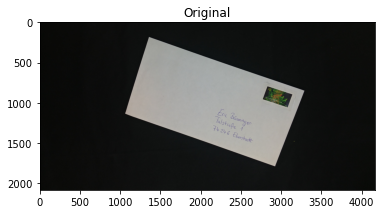

In [3]:
    # Lesen des Bilds
image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
height,width,channels = image.shape
height-=1
width-=1
showImage = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # Zeigen des Bilds
plt.imshow(showImage)
plt.title("Original")


## For Rotating the Picture
https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/

In [4]:
# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to the image file")
# args, unknown =  ap.parse_args(argv[1:])

Text(0.5, 1.0, 'blurred')

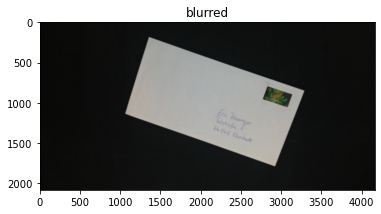

In [5]:
    # Gausian Blur
blurred  = cv2.GaussianBlur(image, (blurring,blurring) , 4, 4,cv2.THRESH_BINARY)
blurredShow = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
plt.imshow(blurredShow)
plt.title("blurred")

## Binarisierung
https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

Text(0.5, 1.0, 'Gray')

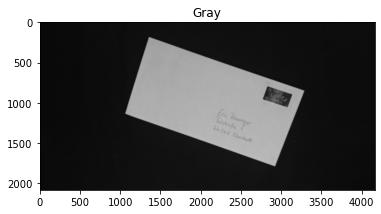

In [6]:
# thresh1 = cv2.adaptiveThreshold(blurred,255,125,cv2.THRESH_BINARY,11,5)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.title("Gray")

Text(0.5, 1.0, 'Canny')

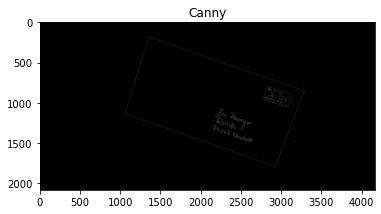

In [7]:
canny = cv2.Canny(gray,0,30)
height,width = canny.shape
plt.imshow(canny, cmap="gray")
plt.title("Canny")

Text(0.5, 1.0, 'dilate')

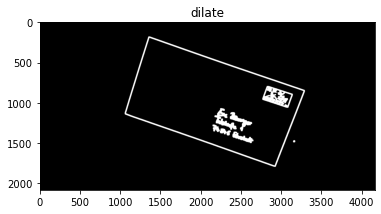

In [8]:
dilate = cv2.dilate(canny,dilateKernel,iterations=1)
plt.imshow(dilate, cmap="gray")
plt.title("dilate")

In [9]:
#highlightedLines = dilate.copy()
#lines = cv2.HoughLinesP(dilate,rho=1,theta=np.pi/360,threshold=1500,minLineLength=1500,maxLineGap=700)
#for line in lines:
#    x1,y1,x2,y2 = line[0]
#    angle = np.arctan((y2-y1)/(x2-x1))
#    print(angle)
#    highlightedLines = cv2.line(dilate,(x1,y1),(x2,y2),color=(0,255,0),thickness=2)
#plt.imshow(highlightedLines)
#cv2.imwrite('houghlines5.jpg',gray)

Text(0.5, 1.0, 'erode')

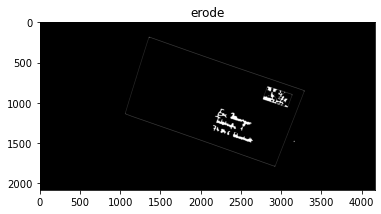

In [10]:
erode = cv2.erode(dilate,erodeKernel,iterations=1)
plt.imshow(erode, cmap="gray")
plt.title("erode")

In [11]:
def align_straight(image):
    img,contours,hierachies = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for index,hierachy in enumerate(hierachies):
        hNext, hPrev, hChild, hParent = hierachy[0]
        if (hChild != -1) and (hParent == -1):      #Extract Parent contour
            contour = contours[0][index]
    center,[letter_W,letter_H],angle = cv2.minAreaRect(contours[1])
    print (center,[letter_W,letter_H],angle)
    if letter_W < letter_H:
        aligned_image = im.rotate_bound(image,-angle+90)
    else:
        aligned_image = im.rotate_bound(image,-angle)
    return aligned_image  

(2154.40478515625, 992.3004150390625) [1007.9071655273438, 2042.887451171875] -70.99431610107422


Text(0.5, 1.0, 'straight-aligned')

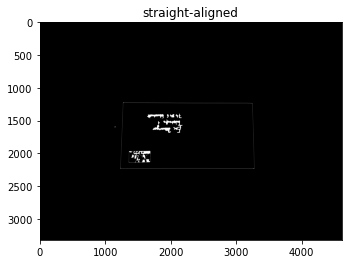

In [12]:
aligned_image = align_straight(erode)
plt.imshow(aligned_image,cmap="gray")
plt.title("straight-aligned")

In [13]:
img,contours,hierachy = cv2.findContours(aligned_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# Hierarchie [Previous, Next, Child, Parent]

In [14]:
def sizeSort(element):
    return len(element)
contours.sort(reverse=True,key=sizeSort)
for index,contour in enumerate(contours):
    if(index<6):
        print(contour.size)

12022
11972
2880
2258
1970
1936


## Get the Moments
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [15]:
# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
def findLetter(contours):
    for contour in contours:
    #( center (x,y), (width, height), angle of rotation ).
        minArea = cv2.minAreaRect(contour)
        width = minArea[1][0]
        height = minArea[1][1]
        print(width,height)
        scale = width/height
        if(scale>C_5_6_Scale[0] and scale<C_5_6_Scale[1]):
            letter = {
                "width": int(width),
                "height" : int(height),
                "centerX" : int(minArea[0][0]),
                "centerY" : int(minArea[0][1]),
                "contour": contour
                }
            return letter

2043.999755859375 1008.9998779296875


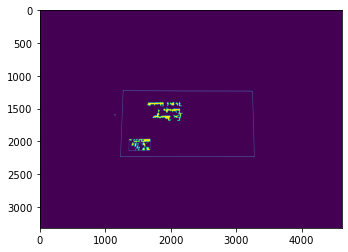

In [16]:
letterValue = findLetter(contours)
# Highlight the Contour of Find Letter and show center of Letter
highlightedContour = aligned_image.copy()
highlightedContour = cv2.circle(highlightedContour,(letterValue["centerX"],letterValue["centerY"]),radius=30, color=(0,0,255),thickness=-1)
cv2.drawContours(highlightedContour, letterValue["contour"], -1, (255, 0, 255), 1) 
plt.imshow(highlightedContour)

## ROI of Letter

Text(0.5, 1.0, 'ROI')

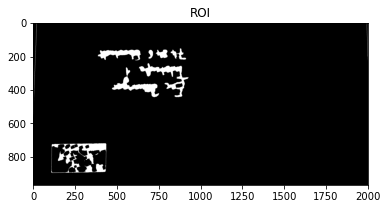

In [17]:
offset = 20
xStart = int(letterValue["centerX"]-letterValue["width"]/2+offset)
xEnd = int(letterValue["centerX"]+letterValue["width"]/2-offset)
yStart = int(letterValue["centerY"]-letterValue["height"]/2+offset)
yEnd = int(letterValue["centerY"]+letterValue["height"]/2-offset)
letter = aligned_image[yStart:yEnd,xStart:xEnd]
plt.imshow(letter, cmap="gray")
plt.title("ROI")

Text(0.5, 1.0, 'stamp zone')

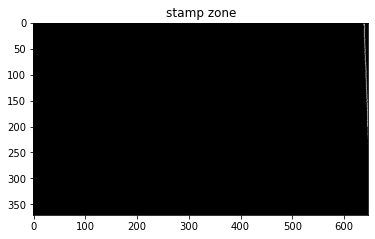

In [18]:
pixelSize = C_5_6_Metrics[0]/letterValue["width"]
# StampZone [width, height] amount of Pixel
stampZoneMetrics = [int(stampZone[0]/pixelSize),int(stampZone[1]/pixelSize)]
# get the rigth Top StampZone
rightTop = letter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
plt.imshow(rightTop, cmap="gray")
plt.title("stamp zone")

### Check if stamp is there

In [19]:
def checkStamp(stampZone, pixelSize):
    imgStamp,cStamp,hStamp = cv2.findContours(stampZone,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    if (len(cStamp)==0):                #No contour found
        return False
    for index,contour in enumerate(cStamp):         
        #( center (x,y), (width, height), angle of rotation ).
        hNext, hPrev, hChild, hParent = hStamp[0][index]
        if (hChild != -1) and (hParent == -1):      #Extract Parent contour
            #TBD: If there are some contours beside the stemp the first and/or second condition would be FALSE...
            minArea = cv2.minAreaRect(contour)
            width = minArea[1][0]
            height = minArea[1][1]
            # stamp minSize 22x28
            contourWidth = width*pixelSize
            contourHeigth = height*pixelSize
            if((contourWidth >= stampMinSize[0]) and (contourHeigth >= stampMinSize[1])):
                stamp_found = True
            else:
                stamp_found = False
    return stamp_found

def align_correct(roiLetter,pixelSize):
    # StampZone [width, height] amount of Pixel
    stampZoneMetrics = [int(stampZone[0]/pixelSize),int(stampZone[1]/pixelSize)]
    # get the rigth Top StampZone
    rightTop = roiLetter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
    stamp_found = checkStamp(rightTop,pixelSize)      
    if stamp_found:
        return roiLetter
    else:
        return im.rotate_bound(roiLetter,180)


Text(0.5, 1.0, 'correct-aligned')

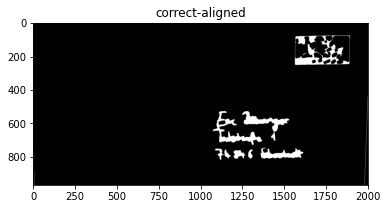

In [20]:
coorect_alligned = align_correct(im.rotate_bound(letter,180),pixelSize)
plt.imshow(coorect_alligned, cmap ="gray")
plt.title("correct-aligned")

In [21]:
# # cutting the edges
# angle = 30
# # M = cv2.getRotationMatrix2D((int(width/2),int(height/2)), angle, 1)
# # rotatedLetter = cv2.warpAffine(showImage,M,(width,height))
# # plt.imshow(rotatedLetter)
# rotated = imutils.rotate_bound(showImage, angle)
# cv2.imshow("Rotated (Correct)", rotated)


### Bekomme den Stream der Kamera und verwandle es in ein grau Stufen Bild
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html?highlight=video

In [22]:
# cap = cv2.VideoCapture(0)

# while(True):
#     # Capture frame-by-frame
#     ret, frame = cap.read()

#     # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=imshow
#     #canny Edge Detection
#     edges = cv2.Canny(gray,100,200)
#     # 1 Fenster mit Graustufe
#     namedWindow1 = "gray"
#     cv2.namedWindow(namedWindow1)
#     cv2.moveWindow(namedWindow1,0,0)
#     cv2.imshow(namedWindow1, gray)
#     # 2 Fenster mit Kantenbild
#     namedWindow2 = "edges"
#     cv2.namedWindow(namedWindow2)
#     cv2.moveWindow(namedWindow2,640,0)
#     cv2.imshow(namedWindow2,edges)
#     # 3 Fenster 
#     namedWindow3 = "weiteres"
#     cv2.namedWindow(namedWindow3)
#     cv2.moveWindow(namedWindow3,1280,0)
#     cv2.imshow(namedWindow3,edges)


#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()

In [23]:
# cv2.waitKey(0)
# cv2.destroyAllWindows()